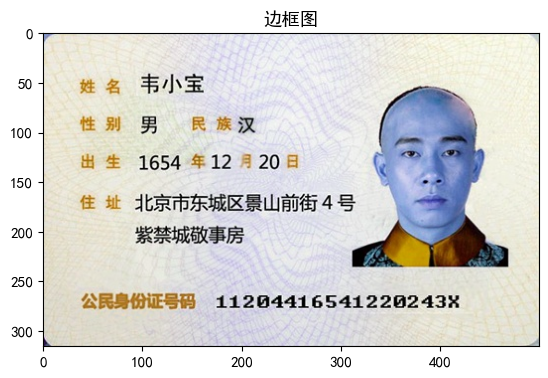

ValueError: zero-size array to reduction operation minimum which has no identity

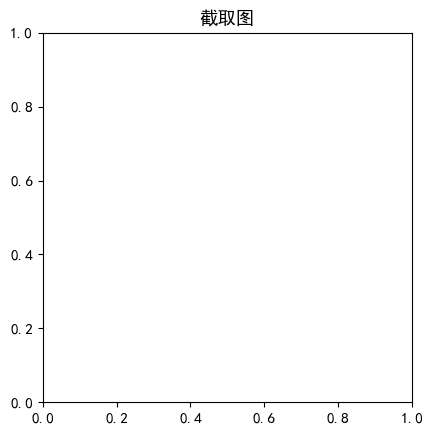

In [2]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from myutils import common
from cnocr import CnOcr
x,y,w,h=(470,750,688,82)
img=cv2.imread("./images/test/20131168257.jpg")
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgc=img.copy()
cv2.rectangle(imgc, (x, y), (x + w, y + h), (0, 0, 255), 1)
common.show(imgc,"边框图",cmap="gray",debug=True)
crop_img = img[y:y+h, x:x+w]
common.show(crop_img,"截取图",cmap="gray",debug=True)
crop_img=common.fillColor(img=crop_img,color=[255, 255, 255],radio=0.5)
crop_img_gray=cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
_,dst=cv2.threshold(crop_img_gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
common.show(dst,"二值化",cmap="gray",debug=True)
kernel = np.ones((3, 3), np.uint8)
dilate = cv2.dilate(dst, kernel, iterations=12)
common.show(dilate, "膨胀",cmap="gray",debug=True)
dilate=cv2.erode(dilate, np.ones((9,9)))
common.show(dilate, "膨胀",cmap="gray",debug=True)
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = crop_img.copy()
res = cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 2)
common.show(image_copy,"边框图",debug=True)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[0]

x,y,w,h = cv2.boundingRect(contours)

"""
cv2.approxPolyDP() 函数拟合出来的轮廓点是一个 N 行 1 列 2 通道的数组，其中 N 表示轮廓点的数量。这个数组的每一行都代表了一个拟合出来的轮廓点的坐标。
通常情况下，拟合出来的轮廓点的坐标是整数类型，表示了这个点在图像中的位置。可以使用这些点绘制轮廓，或者进一步进行图像处理和分析。
需要注意的是，cv2.approxPolyDP() 函数的返回值（拟合的轮廓点）的顺序是按照轮廓的顺序排列的，因此可以使用这个顺序对轮廓进行进一步的处理和分析
可以得到拟合出来的轮廓点数组 approx，
[[[ 31  38]]
 [[ 30 473]]
 [[616 473]]
 [[617  38]]]
 这个数组表示了拟合出来的轮廓点的 x、y 坐标。可以用这些点绘制出拟合出来的轮廓
"""
epsilon = 0.01 * cv2.arcLength(contours, True)

n = []
approx = cv2.approxPolyDP(contours, epsilon, True)
print(approx)
#approx[:, 0, 0] 表示拟合的轮廓点的 x 坐标数组，approx[:, 0, 1] 表示拟合的轮廓点的 y 坐标数组
for x, y in zip(approx[:, 0, 0], approx[:, 0, 1]):
    n.append((x, y))
#按照第一列x进行排序
n = sorted(n)
print(n)
sort_point = []
n_point1 = n[:2]
n_point1.sort(key=lambda x: x[1])
sort_point.extend(n_point1)
n_point2 = n[2:4]
n_point2.sort(key=lambda x: x[1])
n_point2.reverse()
sort_point.extend(n_point2)
p1 = np.array(sort_point, dtype=np.float32)
h = sort_point[1][1] - sort_point[0][1]
w = sort_point[2][0] - sort_point[1][0]
pts2 = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32)
# 生成变换矩阵
M = cv2.getPerspectiveTransform(p1, pts2)
# 进行透视变换
dst = cv2.warpPerspective(image_copy, M, (w, h))
# print(dst.shape)
common.show(dst,"变换图",cmap="gray",debug=True)
ocr = CnOcr(det_model_name='naive_det')  # 所有参数都使用默认值
out = ocr.ocr(dst)
print(out)